In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
train = pd.read_csv('./data/train.csv', index_col='id')
test = pd.read_csv('./data/test.csv', index_col='id')

In [3]:
train.head()

,product_uid,product_title,search_term,relevance
id,,,,
2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [4]:
test.head()

,product_uid,product_title,search_term
id,,,
1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668


In [5]:
y = train.relevance

In [6]:
from sklearn.cross_validation import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=44)

In [8]:
print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(51846, 4) (22221, 4) (51846L,) (22221L,)


In [77]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import PassiveAggressiveRegressor

from sklearn.preprocessing import MinMaxScaler

In [71]:
%run scripts/features.py

In [78]:
ft = FeatureTransformer()
scaler = MinMaxScaler()
clf = PassiveAggressiveRegressor(C=0.1)

online_model_pipe = Pipeline([('ft', ft), ('scaler', scaler), ('clf', clf)])

online_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ft', FeatureTransformer()), ('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', PassiveAggressiveRegressor(C=0.1, class_weight=None, epsilon=0.1,
              fit_intercept=True, loss='epsilon_insensitive', n_iter=5,
              random_state=None, shuffle=True, verbose=0, warm_start=False))])

In [79]:
from sklearn.metrics import mean_squared_error

In [80]:
predsTrain = online_model_pipe.predict(X_train)
predsTest = online_model_pipe.predict(X_test)

In [81]:
print 'RMSE on the training set %f ' %(np.sqrt(mean_squared_error(y_train, predsTrain)))
print 'RMSE on the test set %f ' %(np.sqrt(mean_squared_error(y_test, predsTest)))

RMSE on the training set 0.553286 
RMSE on the test set 0.551892 


In [82]:
# fit on the entire training dataset
online_model_pipe.fit(train, y)

Pipeline(steps=[('ft', FeatureTransformer()), ('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', PassiveAggressiveRegressor(C=0.1, class_weight=None, epsilon=0.1,
              fit_intercept=True, loss='epsilon_insensitive', n_iter=5,
              random_state=None, shuffle=True, verbose=0, warm_start=False))])

In [83]:
predictions = online_model_pipe.predict(test)

In [84]:
def scale_predictions(prediction):
    if prediction > 3.0:
        return 3.0
    elif prediction < 1.0:
        return 1.0
    else:
        return prediction

In [85]:
predictions = map(scale_predictions, predictions)

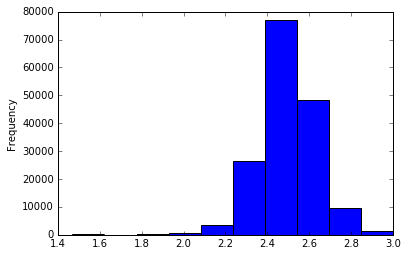

In [86]:
pd.Series(predictions).plot(kind='hist')

In [87]:
# prepare submission file
submission = pd.read_csv('./data/sample_submission.csv')
submission['relevance'] = predictions
submission.to_csv('./submissions/second.csv', index=False)